# Import library

In [75]:
!pip3 install wittgenstein

In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix


#import graphviz
from sklearn.tree import export_graphviz

## Load dataset

In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Adding player's rank on tennis player's profile

In [3]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181501 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          181501 non-null  object 
 1   tourney_name        181501 non-null  object 
 2   surface             181354 non-null  object 
 3   draw_size           181501 non-null  float64
 4   tourney_level       181501 non-null  object 
 5   tourney_date        181501 non-null  object 
 6   match_num           181501 non-null  float64
 7   winner_id           181501 non-null  float64
 8   winner_entry        25298 non-null   object 
 9   winner_name         181501 non-null  object 
 10  winner_hand         181501 non-null  object 
 11  winner_ioc          181501 non-null  object 
 12  winner_age          178681 non-null  float64
 13  loser_id            181501 non-null  float64
 14  loser_entry         43307 non-null   object 
 15  loser_name          181501 non-nul

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
257926  ZUZANA ZLOCHOVA   343.0
257927  ZUZANA ZLOCHOVA   335.0
257928  ZUZANA ZLOCHOVA   316.0
257929  ZUZANA ZLOCHOVA   318.0
257930  ZUZANA ZLOCHOVA   316.0

[257931 rows x 2 columns] 
# of nan: 7622


In [5]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

763

In [6]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2037.000000
mean      490.356406
std       327.419749
min         3.000000
25%       243.000000
50%       422.000000
75%       682.000000
max      1908.000000
Name: rank, dtype: float64

In [7]:
#stampo il numero di giocatori che non hanno nemmeno un valore associato al rank
player.isna().sum()

rank    35
dtype: int64

In [8]:
player['rank'].nunique()

947

In [9]:
#stampo il nome dei giocatori di cui non conosco il rank
player[player['rank'].isna()]

,rank
name,
ABIR EL FAHIMI,NaN
ALEX LAWSON,NaN
AMAL SULTANBEKOV,NaN
AMARNI BANKS,NaN
ANASTASIA IAMACHKINE,NaN
ANNA BOWTELL,NaN
BARBORA PALICOVA,NaN
BREANA STAMPFLI,NaN
CHARLOTTE KEMPENAERS POCZ,NaN


In [10]:
player.reset_index(inplace = True)
player

,name,rank
0,AARON ADDISON,1131.0
1,ABBIE MYERS,475.0
2,ABHINAV SANJEEV SHANMUGAM,1233.0
3,ABIGAIL TERE APISAH,422.0
4,ABIR EL FAHIMI,NaN
...,...,...
2067,ZIZOU BERGS,371.0
2068,ZOE HIVES,319.0
2069,ZOE KRUGER,750.0
2070,ZSOMBOR PIROS,454.0


In [11]:
#unisco le due tabelle
df = pd.merge(df, player, how='left', on='name')

df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.00000,2037.000000
mean,0.486609,100.942085,0.478162,23.541988,0.309913,1993.805502,179.104946,80.432832,6.716569,0.523839,871.927124,7.450516,43.113605,6.698571,6.355497,54.31431,490.356406
std,0.115073,78.005562,0.134808,26.280039,0.264866,5.063032,8.008870,16.122646,5.324856,0.146481,720.860044,3.444339,12.302156,4.583606,1.962237,19.24605,327.419749
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,157.000000,55.472222,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.91000,3.000000
25%,0.423077,28.000000,0.415466,0.000000,0.000000,1990.000000,173.000000,62.607850,2.400000,0.505333,230.000000,5.220000,40.770000,2.550000,5.390000,39.42750,243.000000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.359127,5.755000,0.580575,638.500000,6.950000,47.295000,6.155000,6.615000,64.30500,422.000000
75%,0.565673,170.000000,0.566866,45.000000,0.533333,1998.000000,185.705882,94.008066,9.840000,0.614162,1446.500000,9.172500,50.112500,10.312500,7.552500,69.80000,682.000000
max,0.845161,309.000000,1.000000,101.000000,1.000000,2006.000000,198.000000,145.073643,35.390000,0.949992,3834.000000,29.860000,94.180000,23.310000,17.890000,80.79000,1908.000000


## Transform categorical features into numerical ones

In [12]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [13]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [14]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   num_matches_2016-2019  2072 non-null   float64
 2   ratio_2016-2019        2072 non-null   float64
 3   num_matches_2020-2021  2072 non-null   float64
 4   ratio_2020-2021        2072 non-null   float64
 5   birth                  2072 non-null   float64
 6   ht                     2072 non-null   float64
 7   minutes                2072 non-null   float64
 8   perc_ace               2072 non-null   float64
 9   serv_won_tot_seve      2072 non-null   float64
 10  bpFaced                2072 non-null   float64
 11  perc_df                2072 non-null   float64
 12  perc_2ndwon            2072 non-null   float64
 13  perc_v_ace             2072 non-null   float64
 14  perc_v_df              2072 non-null   float64
 15  perc

### Write to csv before classification

In [16]:
df.to_csv('dataset/players_classification.csv')

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli. Nel nostro caso ci siamo basati sul rank. 

Nota: questa non è una metrica efficace perchè il vero label del giocatore viene calcolato in base a diversi parametri come ad esempio il punteggio realizzato derivante dalla vincita dei vari tornei ma dato che esso risulta difficile stimarlo utilizzare le informazioni sui rank potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili per contraddistinguere i due tipi di giocatori, in paticolare consideriamo i giocatori più forti quelli che compaiono nei primi 25% del dataset in ordine di rank decrescente, mentre i rimanenti risultano di basso livello

In [17]:
df.sort_values(by=['rank'])

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank,hand_num,gender_num,ioc_num
1493,0.845161,229.0,0.829694,81.0,0.888889,1987.0,188.000000,118.034749,10.43,0.675834,1454.0,4.92,54.72,11.15,6.01,65.42,3.0,1,1,78
1782,0.754579,232.0,0.745690,41.0,0.804878,1991.0,168.000000,88.797710,4.19,0.590683,1808.0,5.50,48.38,4.38,7.17,58.06,3.0,1,0,71
1617,0.835616,235.0,0.842553,57.0,0.807018,1986.0,185.000000,122.658811,7.35,0.679608,1377.0,3.69,57.72,12.03,5.78,64.74,3.0,0,1,26
1672,0.828829,202.0,0.841584,20.0,0.700000,1981.0,185.000000,112.136728,17.50,0.712798,874.0,3.41,58.48,10.92,5.65,68.16,4.0,1,1,80
1021,0.699405,270.0,0.711111,66.0,0.651515,1992.0,184.000000,97.553718,15.94,0.618893,2185.0,7.84,45.59,7.41,8.34,63.85,7.0,1,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.133333,15.0,0.133333,0.0,0.000000,1999.0,172.137193,97.307692,3.15,0.391993,159.0,9.15,36.12,2.83,5.98,54.02,NaN,2,0,49
1701,0.379310,8.0,0.375000,21.0,0.380952,2002.0,177.500000,61.904040,3.20,0.409342,305.0,12.49,31.81,0.08,0.49,5.00,NaN,2,0,27
1833,0.500000,16.0,0.500000,0.0,0.000000,1994.0,173.363636,59.750000,0.00,0.130994,72.0,5.81,13.16,1.44,2.89,11.19,NaN,2,0,29
1866,0.380952,21.0,0.380952,0.0,0.000000,1994.0,172.137193,71.658654,0.72,0.482784,139.0,10.25,43.84,1.65,8.06,25.41,NaN,2,0,52


In [18]:
# primo quartile (25%)
quantile_a = df['rank'].quantile(0.25)


In [19]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [20]:
#faccio un drop dei null perchè saranno quelli con cui poi andrò a stimarne il valore
df = df.drop(df[df['rank'].isna()].index)

In [21]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [22]:
class_names = ['high-level', 'low-level']

In [23]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.746686
0    0.253314
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [24]:
del df['rank']

In [25]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [26]:
np.size(train_label)

1527

# Classification 

Abbiamo usato 9 metodi di classificazione diversi al fine di selezionare il migliore in particolare:

**Tree-based classifiers**
- Decision Tree

**Naive Bayes classifiers**
- Bayesian classifier

**Machine Learning classifiers**
- Neural Network

**Neighbors-based classifiers**
- KNN
- Radius-Neighbors 

**Support Vector Machine**
- SVM

**Rule based classifiers**
- Rule based

**Ensemble Method**
- AdaBoosting
- Random forest

## Classfication with decision tree

In [27]:
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

### Grid Search

In [28]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    "class_weight":[None, {0: 0.65, 1: 0.25}]
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, n_jobs=10,
                            scoring=make_scorer(f1_score))

In [29]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 35, 'splitter': 'random'}


In [30]:
blind_pred_dt = dt_grid.predict(blindtest)

In [31]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [32]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png())


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7cbeee", label="X[10] <= 1409.227\ngini = 0.378\nsamples = 1527\nvalue = [387, 1140]\nclass = 1"];
1 [fillcolor="#53aae8", label="X[10] <= 736.913\ngini = 0.206\nsamples = 1112\nvalue = [130, 982]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#43a2e6", label="X[10] <= 484.245\ngini = 0.096\nsamples = 795\nvalue = [40, 755]\nclass = 1"];
1 -> 2;
3 [fillcolor="#3d9fe6", label="X[7] <= 70.935\ngini = 0.037\nsamples = 629\nvalue = [12, 617]\nclass = 1"];
2 -> 3;
4 [fillcolor="#399de5", label="gini = 0.0\nsamples = 204\nvalue = [0, 204]\nclass = 1"];
3 -> 4;
5 [fillcolor="#3fa0e6", label="X[17] <= 0.07\ngini = 0.055\nsamples = 425\nvalue = [12, 413]\nclass = 1"];
3 -> 5;
6 [fillcolor="#8bc6f0", label="gini = 0.415\nsamples = 17\nvalue = [5, 12]\nclass = 1"];
5 -> 6;
7 [fillcolor="#3c9fe5", label="X[5] <= 1994

### Evaluation of the decision tree

In [33]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print(classification_report(train_label, train_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.84      0.87      0.85       387
   low-level       0.95      0.94      0.95      1140

    accuracy                           0.92      1527
   macro avg       0.89      0.90      0.90      1527
weighted avg       0.92      0.92      0.92      1527



In [34]:
print(classification_report(test_label, test_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.77      0.81      0.79       129
   low-level       0.93      0.92      0.93       381

    accuracy                           0.89       510
   macro avg       0.85      0.86      0.86       510
weighted avg       0.89      0.89      0.89       510



/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


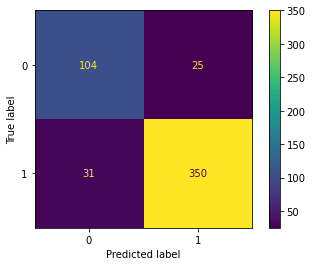

In [35]:
cm = confusion_matrix(test_label, test_pred_dt)
plot_confusion_matrix(dt_grid, test_set, test_label)
plt.show() 

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

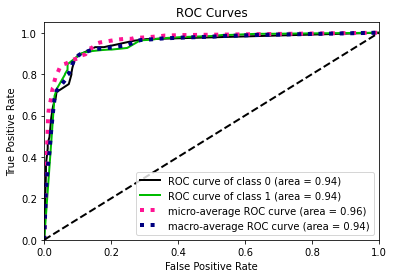

In [36]:
test_pred_proba_dt = dt_grid.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_proba_dt)

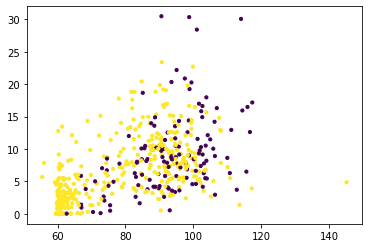

In [37]:
#ace and minutes
plt.scatter(test_set['minutes'], test_set['perc_ace'], c=test_label, s=10);

## Bayesian classifier

In [38]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [39]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [40]:
#compute the performance of the model
print(classification_report(train_label, train_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.65      0.92      0.76       387
   low-level       0.97      0.83      0.89      1140

    accuracy                           0.85      1527
   macro avg       0.81      0.87      0.83      1527
weighted avg       0.89      0.85      0.86      1527



In [41]:
print(classification_report(test_label, test_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.70      0.92      0.80       129
   low-level       0.97      0.87      0.92       381

    accuracy                           0.88       510
   macro avg       0.84      0.90      0.86       510
weighted avg       0.90      0.88      0.89       510



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

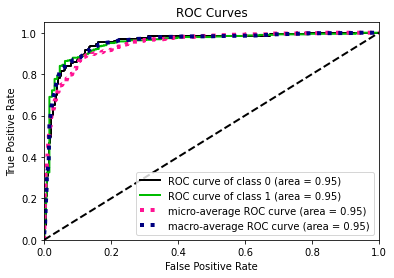

In [42]:
test_pred_proba_gnb = gnb.predict_proba(test_set)
test_pred_proba_gnb
skplt.metrics.plot_roc(test_label, test_pred_proba_gnb)

### 

## Neural Network

In [43]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Init Plugin
Init Graph Optimizer
Init Kernel


In [44]:
def create_model(n_neurons1, activation1, n_neurons2, activation2, optimizer, activation_out, loss): 
    # create model
    model = Sequential()
    model.add(Dense(n_neurons1, kernel_initializer='uniform', input_dim=19, activation=activation1)) 
    model.add(Dense(1,  kernel_initializer='uniform', activation=activation_out))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [45]:
grid_param = {
    "n_neurons1":[20],
    "activation1":["relu"],
    "n_neurons2":[20],
    "activation2":["softmax"],
    "optimizer": ['adam'],
#     "activation_out":["softmax","relu","sigmoid"],
#    "dropout_rate" : [0.2],
    "activation_out":["linear"],
    "loss":["mean_squared_error"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=10, cv=5, scoring=make_scorer(f1_score))


In [46]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1


2021-12-26 17:54:50.505455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-26 17:54:50.506259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-26 17:54:50.506744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-26 17:54:50.506841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Epoch 1/150
39/39 [==============================] - 1s 16ms/step - loss: 1.7862 - accuracy: 0.6293
Epoch 2/150
39/39 [==============================] - 0s 12ms/step - loss: 0.2447 - accuracy: 0.7398
Epoch 3/150
39/39 [==============================] - 1s 13ms/step - loss: 0.1557 - accuracy: 0.7938
Epoch 4/150
39/39 [==============================] - 1s 14ms/step - loss: 0.1757 - accuracy: 0.7357
Epoch 4/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1655 - accuracy: 0.7471
Epoch 5/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1329 - accuracy: 0.8264
Epoch 5/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1004 - accuracy: 0.8732
Epoch 6/150
39/39 [==============================] - 0s 12ms/step - loss: 0.1192 - accuracy: 0.8419
Epoch 6/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1475 - accuracy: 0.7733
Epoch 7/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1306 - accuracy: 0.8298
Epoc

39/39 [==============================] - 0s 10ms/step - loss: 0.1177 - accuracy: 0.8347
Epoch 13/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0877 - accuracy: 0.8895
Epoch 13/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1200 - accuracy: 0.8241
Epoch 14/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0898 - accuracy: 0.8871
Epoch 14/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1195 - accuracy: 0.8632
Epoch 14/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0905 - accuracy: 0.8871
Epoch 15/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0963 - accuracy: 0.8747
Epoch 15/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0897 - accuracy: 0.8953
Epoch 16/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0903 - accuracy: 0.8879
Epoch 16/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1061 - accuracy: 0.8698
Epoch 1

39/39 [==============================] - 0s 11ms/step - loss: 0.0879 - accuracy: 0.8895
Epoch 23/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0838 - accuracy: 0.8928
Epoch 24/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1028 - accuracy: 0.8640
Epoch 24/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0896 - accuracy: 0.8862
Epoch 25/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0821 - accuracy: 0.9043
Epoch 25/150
39/39 [==============================] - 0s 11ms/step - loss: 0.1000 - accuracy: 0.8863
Epoch 27/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0812 - accuracy: 0.8985
Epoch 27/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0887 - accuracy: 0.8804
Epoch 28/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1020 - accuracy: 0.8846
Epoch 29/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0856 - accuracy: 0.8960
Epoc

39/39 [==============================] - 0s 9ms/step - loss: 0.0790 - accuracy: 0.9002
Epoch 34/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0882 - accuracy: 0.8894
Epoch 34/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0838 - accuracy: 0.8927
Epoch 34/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0842 - accuracy: 0.8953
Epoch 35/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0904 - accuracy: 0.8854
Epoch 36/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0965 - accuracy: 0.8953
Epoch 37/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0885 - accuracy: 0.8927
Epoch 36/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0845 - accuracy: 0.8993
Epoch 37/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0852 - accuracy: 0.8862
Epoch 37/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0854 - accuracy: 0.8838
Epoch

39/39 [==============================] - 0s 12ms/step - loss: 0.1019 - accuracy: 0.8773
Epoch 46/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.8755
Epoch 44/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0798 - accuracy: 0.9050
Epoch 45/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0885 - accuracy: 0.8895
Epoch 45/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0818 - accuracy: 0.8993
Epoch 46/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0923 - accuracy: 0.8838
Epoch 46/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1045 - accuracy: 0.8698
Epoch 48/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0872 - accuracy: 0.8928
Epoch 47/150
39/39 [==============================] - 0s 13ms/step - loss: 0.0777 - accuracy: 0.9018
Epoch 49/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0855 - accuracy: 0.8961
Epoc

39/39 [==============================] - 0s 10ms/step - loss: 0.0798 - accuracy: 0.8936
Epoch 55/150
39/39 [==============================] - 0s 10ms/step - loss: 0.1042 - accuracy: 0.8642
Epoch 58/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0914 - accuracy: 0.8804
Epoch 57/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0882 - accuracy: 0.8912
Epoch 59/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0804 - accuracy: 0.9010
Epoch 57/150
39/39 [==============================] - 1s 13ms/step - loss: 0.0886 - accuracy: 0.8886
Epoch 59/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0745 - accuracy: 0.9059
Epoch 59/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0831 - accuracy: 0.8919
Epoch 60/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0771 - accuracy: 0.8985
Epoch 60/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0836 - accuracy: 0.8895
Epoch

39/39 [==============================] - 0s 8ms/step - loss: 0.0930 - accuracy: 0.8764
Epoch 69/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0768 - accuracy: 0.9034
Epoch 68/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0757 - accuracy: 0.8953
Epoch 69/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0777 - accuracy: 0.8969
Epoch 70/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 0.8764
Epoch 73/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0835 - accuracy: 0.8993
Epoch 70/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0931 - accuracy: 0.8812
Epoch 72/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9002
Epoch 74/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0809 - accuracy: 0.9051
Epoch 73/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0735 - accuracy: 0.9133
Epoch 73/1

39/39 [==============================] - 0s 9ms/step - loss: 0.0755 - accuracy: 0.9083
Epoch 78/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0954 - accuracy: 0.8920
Epoch 80/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0918 - accuracy: 0.8969
Epoch 79/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0963 - accuracy: 0.8788
Epoch 79/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0900 - accuracy: 0.8953
Epoch 81/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0827 - accuracy: 0.8927
Epoch 80/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9107
Epoch 82/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0838 - accuracy: 0.9002
Epoch 82/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0840 - accuracy: 0.8920
Epoch 84/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0821 - accuracy: 0.9050
Epoch 83/1

39/39 [==============================] - 0s 11ms/step - loss: 0.0842 - accuracy: 0.8895
Epoch 89/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0728 - accuracy: 0.9083
Epoch 92/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0707 - accuracy: 0.9133
Epoch 93/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 0.8935
Epoch 94/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.9108
Epoch 91/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0732 - accuracy: 0.9051
Epoch 92/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0702 - accuracy: 0.9092
Epoch 93/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0851 - accuracy: 0.8853
Epoch 94/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0726 - accuracy: 0.9083
Epoch 95/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0732 - accuracy: 0.9083
Epoch 96/15

39/39 [==============================] - 0s 9ms/step - loss: 0.0774 - accuracy: 0.8976
Epoch 102/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0736 - accuracy: 0.9002
Epoch 100/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0801 - accuracy: 0.9018
Epoch 100/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0885 - accuracy: 0.8977
Epoch 101/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.9017
Epoch 103/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0731 - accuracy: 0.9043
Epoch 103/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0961 - accuracy: 0.8747
Epoch 102/150
39/39 [==============================] - 0s 11ms/step - loss: 0.1049 - accuracy: 0.8764
Epoch 106/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0896 - accuracy: 0.9001
Epoch 105/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0703 - accuracy: 0.9116
E

39/39 [==============================] - 0s 9ms/step - loss: 0.0783 - accuracy: 0.9091
Epoch 110/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9083
Epoch 111/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0770 - accuracy: 0.9100
Epoch 113/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0972 - accuracy: 0.8822
Epoch 112/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0730 - accuracy: 0.9124
Epoch 112/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0910 - accuracy: 0.9001
Epoch 113/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0770 - accuracy: 0.9002
Epoch 115/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0745 - accuracy: 0.9059
Epoch 114/150
39/39 [==============================] - 0s 9ms/step - loss: 0.1046 - accuracy: 0.8788
Epoch 114/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0722 - accuracy: 0.9149
Ep

39/39 [==============================] - 0s 9ms/step - loss: 0.0690 - accuracy: 0.9165
Epoch 121/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0748 - accuracy: 0.9034
Epoch 122/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0957 - accuracy: 0.8837
Epoch 121/150
39/39 [==============================] - 0s 11ms/step - loss: 0.0773 - accuracy: 0.9067
Epoch 123/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.8960
Epoch 124/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0999 - accuracy: 0.8804
Epoch 125/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0708 - accuracy: 0.9075
Epoch 124/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0697 - accuracy: 0.9141
Epoch 125/150
39/39 [==============================] - 0s 12ms/step - loss: 0.0750 - accuracy: 0.9124
Epoch 125/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0799 - accuracy: 0.909

Epoch 132/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.8993
Epoch 133/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0759 - accuracy: 0.9058
Epoch 132/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0691 - accuracy: 0.9124
Epoch 134/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0755 - accuracy: 0.9083
Epoch 134/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0782 - accuracy: 0.9001
Epoch 133/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9157
Epoch 135/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0711 - accuracy: 0.9124
Epoch 135/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0773 - accuracy: 0.8993
Epoch 137/150
39/39 [==============================] - 0s 11ms/step - loss: 0.1008 - accuracy: 0.8723
Epoch 137/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0742 - acc

39/39 [==============================] - 0s 10ms/step - loss: 0.0758 - accuracy: 0.9050
Epoch 142/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0729 - accuracy: 0.9149
Epoch 145/150
39/39 [==============================] - 1s 13ms/step - loss: 0.0694 - accuracy: 0.9100
Epoch 144/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 0.9026
Epoch 144/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0776 - accuracy: 0.9002
Epoch 145/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0701 - accuracy: 0.9100
Epoch 145/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.8985
Epoch 146/150
39/39 [==============================] - 0s 8ms/step - loss: 0.0709 - accuracy: 0.9116
Epoch 146/150
39/39 [==============================] - 0s 9ms/step - loss: 0.0758 - accuracy: 0.9100
Epoch 147/150
39/39 [==============================] - 0s 10ms/step - loss: 0.0782 - accuracy: 0.9025
E

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")

39/39 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.9034
Epoch 150/150
 1/39 [..............................] - ETA: 0s - loss: 0.1158 - accuracy: 0.7812

2021-12-26 17:55:49.170672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 17:55:49.221241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/39 [==============================] - 0s 6ms/step - loss: 0.0749 - accuracy: 0.9034


2021-12-26 17:55:49.410481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), a

Metal device set to: Apple M1
Epoch 1/150
 1/48 [..............................] - ETA: 8s - loss: 31.3459 - accuracy: 0.8125

2021-12-26 17:55:49.876091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-26 17:55:49.876337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-26 17:55:49.973467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 0s 4ms/step - loss: 2.4483 - accuracy: 0.6110
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1625 - accuracy: 0.8055
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1298 - accuracy: 0.8238
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.8324
Epoch 5/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 0.8481
Epoch 6/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1062 - accuracy: 0.8671
Epoch 7/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.8638
Epoch 8/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.8697
Epoch 9/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1025 - accuracy: 0.8684
Epoch 10/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1009 - accuracy: 0.8749
Epoch 11/150
48/48 [=

48/48 [==============================] - 0s 5ms/step - loss: 0.0770 - accuracy: 0.8952
Epoch 84/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9064
Epoch 85/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9083
Epoch 86/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0841 - accuracy: 0.8959
Epoch 87/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0731 - accuracy: 0.9070
Epoch 88/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.9142
Epoch 89/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0749 - accuracy: 0.9024
Epoch 90/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.9109
Epoch 91/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9064
Epoch 92/150
48/48 [==============================] - 0s 4ms/step - loss: 0.0754 - accuracy: 0.9064
Epoch 93/150


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-26 17:56:20.006158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), a

In [47]:
print(classification_report(train_label, train_pred_nn, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.94      0.61      0.74       387
   low-level       0.88      0.99      0.93      1140

    accuracy                           0.89      1527
   macro avg       0.91      0.80      0.84      1527
weighted avg       0.90      0.89      0.88      1527



In [48]:
print(classification_report(test_label, test_pred_nn, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.90      0.63      0.74       129
   low-level       0.89      0.98      0.93       381

    accuracy                           0.89       510
   macro avg       0.89      0.80      0.83       510
weighted avg       0.89      0.89      0.88       510



### Accuracy

In [49]:
test=best_model.best_estimator_
history=test.fit(train_set, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.4)

Epoch 1/120
2/2 [==============================] - 0s 97ms/step - loss: 25.2052 - accuracy: 0.7478 - val_loss: 7.8321 - val_accuracy: 0.7447
Epoch 2/120
2/2 [==============================] - 0s 16ms/step - loss: 5.0944 - accuracy: 0.7587 - val_loss: 1.5059 - val_accuracy: 0.7938
Epoch 3/120
2/2 [==============================] - 0s 17ms/step - loss: 2.6210 - accuracy: 0.7085 - val_loss: 4.9349 - val_accuracy: 0.2700
Epoch 4/120
1/2 [==============>...............] - ETA: 0s - loss: 6.0009 - accuracy: 0.2740

2021-12-26 17:56:20.201270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-26 17:56:20.308764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 18ms/step - loss: 6.2933 - accuracy: 0.2576 - val_loss: 5.6743 - val_accuracy: 0.2553
Epoch 5/120
2/2 [==============================] - 0s 24ms/step - loss: 5.9080 - accuracy: 0.2522 - val_loss: 2.9666 - val_accuracy: 0.2553
Epoch 6/120
2/2 [==============================] - 0s 19ms/step - loss: 2.7211 - accuracy: 0.2522 - val_loss: 0.6460 - val_accuracy: 0.4223
Epoch 7/120
2/2 [==============================] - 0s 16ms/step - loss: 0.5610 - accuracy: 0.5797 - val_loss: 0.3100 - val_accuracy: 0.7627
Epoch 8/120
2/2 [==============================] - 0s 17ms/step - loss: 0.4261 - accuracy: 0.7489 - val_loss: 1.1599 - val_accuracy: 0.7414
Epoch 9/120
2/2 [==============================] - 0s 17ms/step - loss: 1.3080 - accuracy: 0.7478 - val_loss: 1.7947 - val_accuracy: 0.7447
Epoch 10/120
2/2 [==============================] - 0s 16ms/step - loss: 1.7672 - accuracy: 0.7478 - val_loss: 1.5942 - val_accuracy: 0.7447
Epoch 11/120
2/2 [=============

2/2 [==============================] - 0s 17ms/step - loss: 0.1262 - accuracy: 0.8199 - val_loss: 0.1261 - val_accuracy: 0.8183
Epoch 63/120
2/2 [==============================] - 0s 17ms/step - loss: 0.1256 - accuracy: 0.8221 - val_loss: 0.1258 - val_accuracy: 0.8200
Epoch 64/120
2/2 [==============================] - 0s 16ms/step - loss: 0.1251 - accuracy: 0.8199 - val_loss: 0.1253 - val_accuracy: 0.8200
Epoch 65/120
2/2 [==============================] - 0s 16ms/step - loss: 0.1246 - accuracy: 0.8210 - val_loss: 0.1250 - val_accuracy: 0.8200
Epoch 66/120
2/2 [==============================] - 0s 16ms/step - loss: 0.1241 - accuracy: 0.8231 - val_loss: 0.1245 - val_accuracy: 0.8200
Epoch 67/120
2/2 [==============================] - 0s 16ms/step - loss: 0.1238 - accuracy: 0.8242 - val_loss: 0.1244 - val_accuracy: 0.8183
Epoch 68/120
2/2 [==============================] - 0s 15ms/step - loss: 0.1230 - accuracy: 0.8242 - val_loss: 0.1234 - val_accuracy: 0.8265
Epoch 69/120
2/2 [========

2/2 [==============================] - 0s 16ms/step - loss: 0.1054 - accuracy: 0.8723 - val_loss: 0.1056 - val_accuracy: 0.8609


### Print accuracy of best models

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_14097/3007715566.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_14097/3007715566.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')


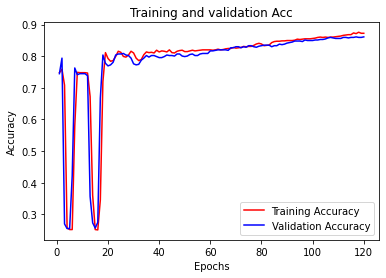

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Print accuracy of best models

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_14097/2382457563.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_14097/2382457563.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')


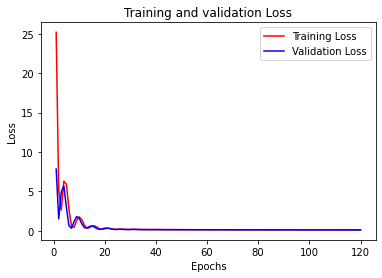

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [53]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 10
k_range = []
for i in range(0,20):
    k_range.append(k)
    k = k + 1

In [54]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring=make_scorer(f1_score))

In [55]:
knn_grid.fit(train_set_no_cat, train_label)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                                         39, 40, 41, 42, 43, 44, 45, 46, 47,
                                         48],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score))

In [56]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

In [57]:
print(classification_report(train_label, train_pred_knn, target_names=class_names))

              precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       387
   low-level       1.00      1.00      1.00      1140

    accuracy                           1.00      1527
   macro avg       1.00      1.00      1.00      1527
weighted avg       1.00      1.00      1.00      1527



In [58]:
print(classification_report(test_label, test_pred_knn, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.84      0.70      0.76       129
   low-level       0.90      0.96      0.93       381

    accuracy                           0.89       510
   macro avg       0.87      0.83      0.85       510
weighted avg       0.89      0.89      0.89       510



## Radius-Neighbors Classifier 

### Grid search

In [91]:
from sklearn.neighbors import RadiusNeighborsClassifier
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

### Training

In [92]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=10, scoring='accuracy')

radius_grid.fit(train_set_no_cat, train_label)

print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.8238089095287237
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'radius': 4418856.223389449, 'weights': 'distance'}


In [94]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set_no_cat, train_label)

### Evaluation

In [95]:
test_pred_radius = radius.predict(test_set_no_cat)
print(classification_report(test_label, test_pred_radius, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.78      0.36      0.49       129
   low-level       0.82      0.97      0.88       381

    accuracy                           0.81       510
   macro avg       0.80      0.66      0.69       510
weighted avg       0.81      0.81      0.78       510



## SVM

In [64]:
from sklearn.svm import SVC

In [65]:
svm_param_grid = {
    'C' : [0.5, 2.0],
    'kernel' : ['rbf', 'linear'] 
    }
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, n_jobs=10, cv=10, scoring=make_scorer(f1_score))

In [66]:
svm_grid.fit(train_set, train_label)

GridSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=10,
             param_grid={'C': [0.5, 2.0], 'kernel': ['rbf', 'linear']},
             scoring=make_scorer(f1_score))

In [67]:
train_pred_svm = svm_grid.predict(train_set)
test_pred_svm = svm_grid.predict(test_set)

In [68]:
print('---TRAIN report:---\n', classification_report(train_label, train_pred_svm, target_names=class_names))
print('---TEST report:---\n',classification_report(test_label, test_pred_svm, target_names=class_names))

---TRAIN report:---
               precision    recall  f1-score   support

  high-level       0.90      0.86      0.88       387
   low-level       0.95      0.97      0.96      1140

    accuracy                           0.94      1527
   macro avg       0.93      0.91      0.92      1527
weighted avg       0.94      0.94      0.94      1527

---TEST report:---
               precision    recall  f1-score   support

  high-level       0.86      0.86      0.86       129
   low-level       0.95      0.95      0.95       381

    accuracy                           0.93       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.93      0.93      0.93       510



/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


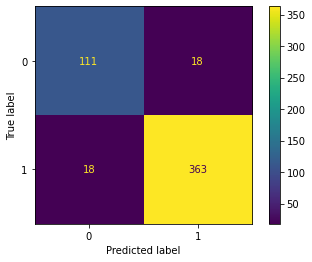

In [69]:
cm = confusion_matrix(test_label, test_pred_svm)
plot_confusion_matrix(svm_grid, test_set, test_label)
plt.show() 

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

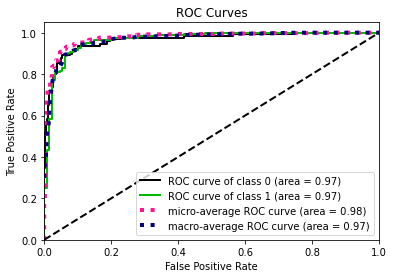

In [70]:
test_pred_proba_svm = svm_grid.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_proba_svm)

## Rule Based Classifier

In [99]:
import wittgenstein as lw
param_grid = {
    "prune_size": [0.1, 0.2, 0.5, 0.6], 
    "k": [1, 3, 7, 10]
}
rb_grid = GridSearchCV(lw.RIPPER(), param_grid=param_grid, n_jobs=10)

ModuleNotFoundError: No module named 'wittgenstein'

In [ ]:
rb_grid.fit(train_set, train_label)

In [ ]:
rb = rb_grid.best_estimator_
rb.out_model()

In [ ]:
train_pred_rb = rb_grid.predict(train_set)
test_pred_rb = rb_grid.predict(test_set)
print('---TRAIN report:---\n', classification_report(train_label, train_pred_rb, target_names=class_names))
print('---TEST report:---\n',classification_report(test_label, test_pred_rb, target_names=class_names))

## Random Forest Classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.65, 1: 0.35}]}

rf_grid = RandomizedSearchCV(RandomForestClassifier(n_estimators=30), param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))


In [79]:
#run the grid search
rf_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.65, 1: 0.35}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12e6a8460>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12fc1b7c0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12fa30c10>},
                   scoring=make_scorer(accuracy_score))

In [80]:
train_pred_rf = rf_grid.predict(train_set)
test_pred_rf = rf_grid.predict(test_set)

In [81]:
print('---TRAIN report:---\n', classification_report(train_label, train_pred_rf, target_names=class_names))
print('---TEST report:---\n',classification_report(test_label, test_pred_rf, target_names=class_names))

---TRAIN report:---
               precision    recall  f1-score   support

  high-level       0.88      0.92      0.90       387
   low-level       0.97      0.96      0.97      1140

    accuracy                           0.95      1527
   macro avg       0.93      0.94      0.93      1527
weighted avg       0.95      0.95      0.95      1527

---TEST report:---
               precision    recall  f1-score   support

  high-level       0.84      0.84      0.84       129
   low-level       0.95      0.95      0.95       381

    accuracy                           0.92       510
   macro avg       0.90      0.90      0.90       510
weighted avg       0.92      0.92      0.92       510



/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


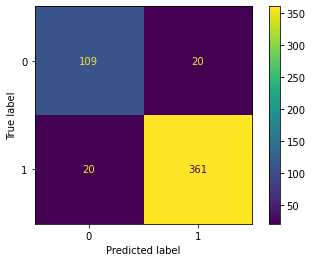

In [82]:
cm = confusion_matrix(test_label, test_pred_rf)
plot_confusion_matrix(rf_grid, test_set, test_label)
plt.show() 

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

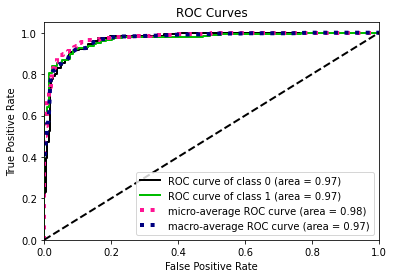

In [83]:
test_pred_proba_rf = rf_grid.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_proba_rf)

## AdaBoosting

In [102]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(train_set, train_label)

AdaBoostClassifier()

In [103]:
test_pred_abc = abc.predict(test_set)
print(classification_report(test_label, test_pred_abc, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.85      0.81      0.83       129
   low-level       0.94      0.95      0.94       381

    accuracy                           0.92       510
   macro avg       0.89      0.88      0.89       510
weighted avg       0.91      0.92      0.92       510



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

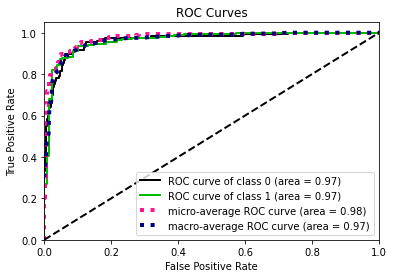

In [105]:
test_pred_abc = abc.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_abc)

## Global models evaluation

Compare results on test set of each model obtained with grid search

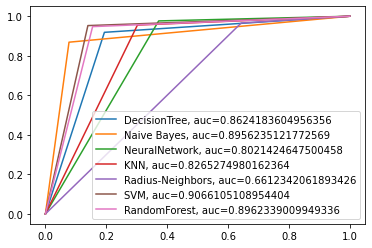

In [108]:
## aggiungi gli altri modelli sotto 

#decision tree 
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

#bayesian classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

#neural network
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NeuralNetwork, auc="+str(auc))

#KNN
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

#Radius-Neighbors
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_radius)
auc = metrics.roc_auc_score(test_label, test_pred_radius)
plt.plot(fpr,tpr,label="Radius-Neighbors, auc="+str(auc))

#SVM
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#Rule Based Classifier
#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rb)
#auc = metrics.roc_auc_score(test_label, test_pred_rb)
#plt.plot(fpr,tpr,label="RuleBasedClassifier, auc="+str(auc))

#RandomForest
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

#AdaBoosting
#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_abc)
#auc = metrics.roc_auc_score(test_label, test_pred_abc)
#plt.plot(fpr,tpr,label="AdaBoosting, auc="+str(auc))

plt.legend(loc=0)